In [73]:
# 필요한 lib import
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import drive

# google drive mount
drive.mount('/content/drive')

# read train.csv
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

# price_range를 예측하는 모델을 만들기 위해서 X와 y로 분리
X=data.drop(['price_range'],axis=1)
y=data['price_range']
print(X.head())
print(X.shape)
print(y.head())
print(y.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2   2         20       756  2549     9     7         19   
1        136        3   6        905      1988  2631    17     3          7   
2        145        5   6       1263      1716  2603    11     2          9   
3        131        6   9       1216      1786  2769    16     8         1

In [74]:
# assignment intro에 따라 8:1:1로 데이터를 나누고, random_state를 42로 설정했을 때, 학습시킨 후 acc가 0.7466..을로 나오는지 확인
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.3,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)
print(X_train.shape,X_val.shape,X_test.shape)
clf=LogisticRegression(penalty=None,solver='sag',random_state=0,max_iter=100000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
accuracy_score_all=accuracy_score(y_test,y_pred)
print(accuracy_score_all)

(1400, 20) (300, 20) (300, 20)
0.7466666666666667


In [75]:
# Correlation을 사용하여 price_range와 가장 연관이 있는 top4 features가 무엇인지 확인
corr=data.corr()
corr=corr['price_range'].sort_values(ascending=False)
top_features=list(corr[1:5].index)
print(f"Top4 features based on Correlation: {top_features}")

Top4 features based on Correlation: ['ram', 'battery_power', 'px_width', 'px_height']


In [76]:
# Chi-square test를 사용하여 price_range와 가장 연관이 있는 top4 features가 무엇인지 확인
from scipy import stats
pr=data['price_range']
chi2_df=pd.DataFrame(columns=X_train.columns)
temp=[]
for col in X_train.columns:
  data_cross=pd.crosstab(pr, data[col])
  chi2=stats.chi2_contingency(data_cross, correction = False)
  temp.append(chi2[0])
chi2_df.loc[chi2_df.shape[0]]=temp
chi2_df=chi2_df.T.sort_values(by=0, ascending=False)
top_features=list(chi2_df[0:4].index)
print(f"Top4 features based on Chi-square test: {top_features}")

Top4 features based on Chi-square test: ['ram', 'px_height', 'battery_power', 'px_width']


In [77]:
# Forward feature selection를 사용하여 price_range와 가장 연관이 있는 top4 features가 무엇인지 확인
# feature의 개수를 1개부터 4개까지 늘리면서 해당 feature의 조합이 price_range와 얼마나 상관이 있는지 평가
from sklearn.metrics import r2_score
features=X_train.columns
top_features=[]
for _ in range(4):
  max_score=0
  best_features=[]
  for f in features:
    temp_features=top_features.copy()
    temp_features.append(f)
    X_train_ffs=X_train[temp_features]
    X_test_ffs=X_test[temp_features]
    clf=LogisticRegression(penalty=None,solver='sag',random_state=0,max_iter=100000)
    clf.fit(X_train_ffs,y_train)
    y_pred=clf.predict(X_test_ffs)
    temp_score=accuracy_score(y_test,y_pred)
    # print(temp_features, accuracy_score(y_test,y_pred))
    if(max_score<temp_score):
      max_score=temp_score
      best_features=temp_features
  top_features=best_features
  features=list(set(features).difference(set(top_features)))
print(f"Top4 features based on Forward feature selection: {top_features}")

Top4 features based on Forward feature selection: ['pc', 'ram', 'mobile_wt', 'clock_speed']


In [78]:
# PCA를 사용하여 top4 features가 무엇인지 확인
from sklearn.decomposition import PCA
pca=PCA(n_components=4)
pca.fit(X_train)
loading_df=pd.DataFrame(pca.components_, columns=[f for f in X_train])
top_features=[]
for i in range(4):
    component=loading_df.iloc[i]
    top_features.extend(component.abs().nlargest(1).index)
top_features=list(set(top_features))
print(f"Top4 features based on PCA: {top_features}")

Top4 features based on PCA: ['px_height', 'ram', 'px_width', 'battery_power']


In [79]:
# top4 features를 이용하여 accuracy 측정1
# Correlation, Chi-square test, PCA 방법을 사용해서 얻은 top4 features를 사용
# ['px_width', 'battery_power', 'ram', 'px_height']
selected_features = ['px_width', 'battery_power', 'ram', 'px_height']
X_train_4f=X_train[selected_features]
X_test_4f=X_test[selected_features]
print(X_train_4f.shape)
print(X_test_4f.shape)
clf=LogisticRegression(penalty=None,solver='sag',random_state=0,max_iter=100000)
clf.fit(X_train_4f,y_train)
y_pred=clf.predict(X_test_4f)
accuracy_score_4=accuracy_score(y_test,y_pred)
print(accuracy_score_4)

(1400, 4)
(300, 4)
0.5366666666666666


In [80]:
print(f'전체 features를 사용했을 때의 accuracy score: {round(accuracy_score_all,2)}')
print(f'Top4 features를 사용했을 때의 accuracy score: {round(accuracy_score_4,2)} (Correlation, Chi-square test, PCA)')

전체 features를 사용했을 때의 accuracy score: 0.75
Top4 features를 사용했을 때의 accuracy score: 0.54 (Correlation, Chi-square test, PCA)


In [81]:
# top4 features를 이용하여 accuracy 측정2
# Forward feature selection 방법을 사용해서 얻은 top4 features를 사용
# ['pc', 'ram', 'mobile_wt', 'clock_speed']
selected_features = ['pc', 'ram', 'mobile_wt', 'clock_speed']
X_train_4f=X_train[selected_features]
X_test_4f=X_test[selected_features]
print(X_train_4f.shape)
print(X_test_4f.shape)
clf=LogisticRegression(penalty=None,solver='sag',random_state=0,max_iter=100000)
clf.fit(X_train_4f,y_train)
y_pred=clf.predict(X_test_4f)
accuracy_score_4=accuracy_score(y_test,y_pred)
print(accuracy_score_4)

(1400, 4)
(300, 4)
0.7


In [82]:
print(f'전체 features를 사용했을 때의 accuracy score: {round(accuracy_score_all,2)}')
print(f'Top4 features를 사용했을 때의 accuracy score: {round(accuracy_score_4,2)} (Forward feature selection)')

전체 features를 사용했을 때의 accuracy score: 0.75
Top4 features를 사용했을 때의 accuracy score: 0.7 (Forward feature selection)


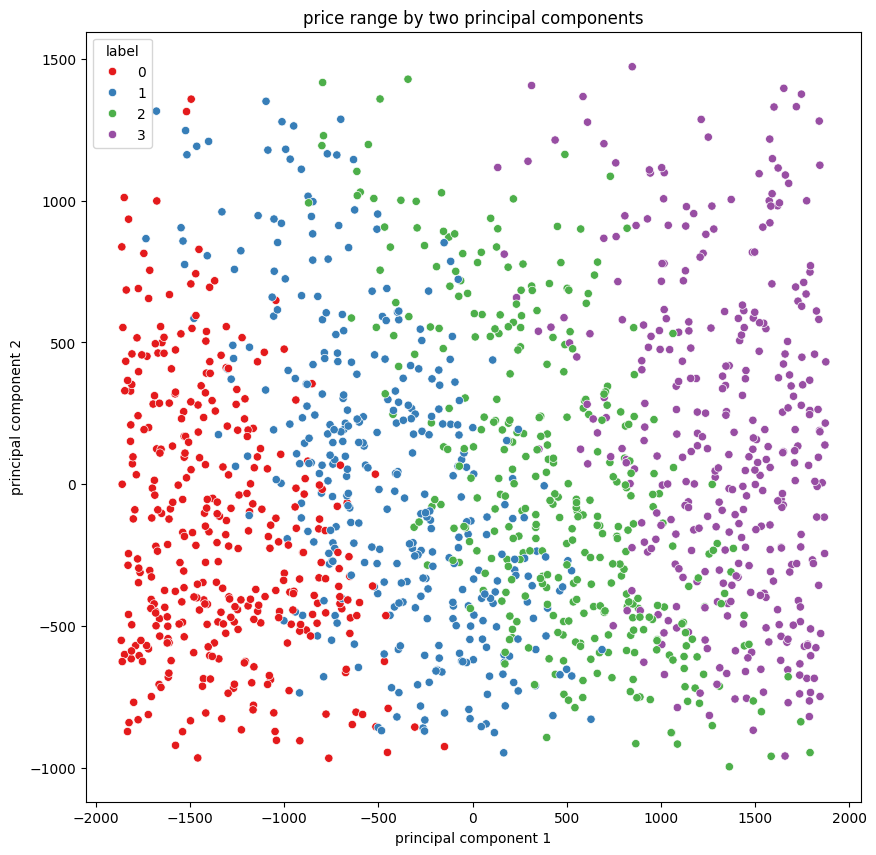

In [87]:
# seaborn을 이용해 visualization
import seaborn as sns
import matplotlib.pyplot as plt

# 일반적으로 데이터를 시각화하기 위해서는 2D 또는 3D를 선택하기 때문에 n_component를 2로 설정
pca=PCA(n_components=2)
X_train_pca=pca.fit_transform(X_train)
df_pca = pd.DataFrame(data=X_train_pca, columns=['PC1', 'PC2'])
y_train=y_train.reset_index(drop=True)
df_pca['label']=y_train

# visualization
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue='label', palette='Set1', data=df_pca)
plt.title('price range by two principal components')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

In [ ]:
# Q4

In [136]:
# Feature Scaling을 위해 MinMaxScaler import
from sklearn.preprocessing import MinMaxScaler

# 0~1의 값을 가지지 않는 feature를 분류
num=['battery_power','clock_speed','fc','int_memory','mobile_wt',
     'n_cores','pc','px_height','px_width','ram','sc_h','sc_w',
     'talk_time']
etc=['blue','dual_sim','four_g','m_dep','three_g','touch_screen',
     'wifi']
X_num=X[num]
minmax_scaler=MinMaxScaler()
X_scaled=pd.DataFrame(minmax_scaler.fit_transform(X_num))

# 분류하지 않았던 남은 feature들을 다시 결합
for feature in etc:
  X_scaled[X_scaled.shape[1]]=X[feature]

X_train,X_temp,y_train,y_temp=train_test_split(X_scaled,y,test_size=0.3,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)
clf=LogisticRegression(penalty=None,solver='sag',random_state=0,max_iter=100000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9833333333333333
